<a href="https://colab.research.google.com/github/jinhan814/GAN-implementation/blob/main/VanillaGAN/VanillaGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [ ]:
import numpy as np
import os, sys
import datetime
import random

In [ ]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [ ]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, image_dim=28):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.image_dim  = image_dim
        self.layer = nn.Sequential(nn.Linear(latent_dim, 128),
                                   nn.ReLU(),
                                   nn.Linear(128, 256),
                                   nn.ReLU(),
                                   nn.Linear(256, image_dim**2),
                                   nn.Tanh())
    
    def forward(self, x):
        x = self.layer(x)
        x = x.view(x.size(0), 1, self.image_dim, self.image_dim)
        return x

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, image_dim=28):
        super(Discriminator, self).__init__()
        self.image_dim = image_dim
        self.layer = nn.Sequential(nn.Linear(image_dim**2, 512),
                                   nn.ReLU(),
                                   nn.Linear(512, 256),
                                   nn.Dropout(0.3),
                                   nn.ReLU(),
                                   nn.Linear(256, 1),
                                   nn.Dropout(0.3),
                                   nn.Sigmoid())
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layer(x)
        return x

In [ ]:
# -- hyperparameter
seed        = 42
epochs      = 30
batch_size  = 64

# -- setting
seed_everything(seed)
use_cuda    = torch.cuda.is_available()
device      = torch.device('cuda' if use_cuda else 'cpu')

# -- dataset, data_loader
transform   = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5],
                                    std=[0.5])])
mnist       = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

# -- model & loss & optimizer
G           = Generator().to(device)
D           = Discriminator().to(device)
criterion   = nn.BCELoss()
optimizer_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

# -- label
label_real  = torch.ones(batch_size, 1).to(device)
label_fake  = torch.zeros(batch_size, 1).to(device)

for epoch in range(epochs):
    G.train()
    D.train()
    for step, (img, _) in enumerate(data_loader):
        # -- train D
        x = img.to(device)
        z = torch.randn(batch_size, 100).to(device)
        loss_D = criterion(D(x), label_real) + criterion(D(G(z)), label_fake)
        D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # -- train G
        z = torch.randn(batch_size, 100).to(device)
        loss_G = criterion(D(G(z)), label_real)
        G.zero_grad()
        loss_G.backward()
        optimizer_G.step()
        if (step + 1) % 300 == 0:
            print(f'Epoch: {epoch+1}/{epochs}\t Step: {step+1}/{len(data_loader)}\t Loss_D: {loss_D.item():.6f}\t Loss_G: {loss_G.item():.6f}')

Epoch: 1/30	 Step: 300/937	 Loss_D: 0.586870	 Loss_G: 1.762484
Epoch: 1/30	 Step: 600/937	 Loss_D: 0.812379	 Loss_G: 2.407818
Epoch: 1/30	 Step: 900/937	 Loss_D: 0.546824	 Loss_G: 1.619608
Epoch: 2/30	 Step: 300/937	 Loss_D: 0.486097	 Loss_G: 2.860870
Epoch: 2/30	 Step: 600/937	 Loss_D: 0.740496	 Loss_G: 3.267533
Epoch: 2/30	 Step: 900/937	 Loss_D: 0.507905	 Loss_G: 3.120898
Epoch: 3/30	 Step: 300/937	 Loss_D: 0.609649	 Loss_G: 1.731840
Epoch: 3/30	 Step: 600/937	 Loss_D: 0.592689	 Loss_G: 2.122647
Epoch: 3/30	 Step: 900/937	 Loss_D: 0.510797	 Loss_G: 2.712614
Epoch: 4/30	 Step: 300/937	 Loss_D: 0.750487	 Loss_G: 3.185861
Epoch: 4/30	 Step: 600/937	 Loss_D: 0.581354	 Loss_G: 2.233576
Epoch: 4/30	 Step: 900/937	 Loss_D: 0.506154	 Loss_G: 2.417577
Epoch: 5/30	 Step: 300/937	 Loss_D: 0.525089	 Loss_G: 2.090361
Epoch: 5/30	 Step: 600/937	 Loss_D: 0.557574	 Loss_G: 3.694282
Epoch: 5/30	 Step: 900/937	 Loss_D: 0.639716	 Loss_G: 1.774685
Epoch: 6/30	 Step: 300/937	 Loss_D: 0.742530	 Loss_G: 2

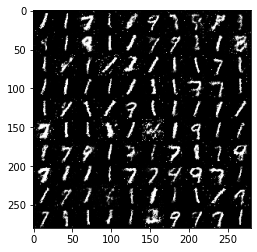

In [ ]:
# -- inference
def inference():
    z = torch.randn(100, 100).to(device)
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([280, 280])
    for i in range(10): img[i*28:(i+1)*28] = np.concatenate([x for x in result[i*10:(i+1)*10]], axis=-1)
    return img

G.eval()
imshow(inference(), cmap='gray')